In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm
from pathlib import Path
from geovision.data.fmow import FMoW
from matplotlib.patches import Rectangle

**Performing EDA on the FMoW dataset**
- **Dataset Description**: 
- **Potential Utility**:
    1. Single Image Classification + Localization 
    2. Multi Image (Time Series) Classification 
    3. Sentinel 2 MS (10m) to Worldview/GeoEye RGB (30cm-1m) Super-Resolution
    4. Change Detection (Segmentation)
- **Exploration**
    1. Categorical Distribution (Imbalance and Semantic Meaning)
    2. Geographic Distribution (Jointly with Categorical)  
    3. Background Clutter Reduction 
        -> Classification Dataset: Crop To BBox -> (1024x1024x5) Tiles
            1. Limited Context (Focus on Foreground)
            2. Preserve Scale and Aspect Ratio (High Resolution and Use Padding If Needed, Scale Aug. at load time)
        -> Detection Dataset: (Crop To BBox + 10% Extra Context)
            1. Preserve BBoxes
    4. Temporal Distribution ()
    5. 

In [3]:
index_df = FMoW.load('index', 'imagefolder', 'rgb')
spatial_df = FMoW.load('spatial', 'imagefolder', 'rgb')

In [4]:
# FMoW has 62 categorical labels. We want to see the distribution of the data globally and across the categories, so we expand the tables such that
# each label and it's corresponding bbox is a unique row [multilabel -> multiclass]. Then we create some new columns: 
# - image_pixels: # pixels, not counting channels, in the image; loosely proportional to the area covered by the image on the ground.
# - bbox_pixels: # pixels bounded by the label bbox; loosely proportional to the area covered by the object of interest on the ground. 
# - label_pixels: ratio of pixels bounded by label bbox to the total pixels in the image; smaller number indicates more background.
# - image_aspect: width::height ratio of the image; >1 indicates wider images, <1 indicates taller images
# - bbox_aspect: width::height ratio of the bbox; >1 indicates wider bbox, <1 indicates taller bbox

class_dist = {i: list() for i in ("idx", "label_str", "bbox_height", "bbox_width")} 
for idx, row in tqdm(index_df.iterrows(), total = len(index_df)):
    for label_str, bbox_dims in zip(row["label_str"], row["label_bbox"]):
        class_dist["idx"].append(idx)
        class_dist["label_str"].append(label_str)
        class_dist["bbox_height"].append(bbox_dims[2] - bbox_dims[0])
        class_dist["bbox_width"].append(bbox_dims[3] - bbox_dims[1])

df = (
    pd.merge(
        left = (
            index_df[["image_path"]]
            .merge(spatial_df[["img_width", "img_height", "utm", "country_code"]], how = "left", left_index=True, right_index=True)
            .assign(image_pixels = lambda df: df["img_width"]*df["img_height"])
            .assign(image_aspect = lambda df: df["img_width"]/df["img_height"])
            #.drop(columns = ["img_width", "img_height"])
        ),
        right = (
            pd.DataFrame(class_dist)
            .set_index("idx")
            .assign(bbox_pixels = lambda df: df["bbox_width"]*df["bbox_height"])
            .assign(bbox_aspect = lambda df: df["bbox_width"]/df["bbox_height"])
        ), 
        how = "right", 
        left_index=True, 
        right_index=True
    )
    #.drop(columns=["bbox_height", "bbox_width"])
    .reset_index(names=["image_idx"])
    .assign(label_pixels = lambda df: df["bbox_pixels"] / df["image_pixels"])
)

df

100%|██████████| 523846/523846 [00:23<00:00, 22401.39it/s]


,image_idx,image_path,img_width,img_height,utm,country_code,image_pixels,image_aspect,label_str,bbox_height,bbox_width,bbox_pixels,bbox_aspect,label_pixels
0,0,seq_gt/airport/airport_0/airport_0_0_rgb.jpg,8792,8792,36N,SSD,77299264,1.000000,airport,1269,1127,1430163,0.888101,0.018502
1,1,seq_gt/airport/airport_0/airport_0_1_rgb.jpg,8624,8624,36N,SSD,74373376,1.000000,airport,1244,1106,1375864,0.889068,0.018499
2,2,seq_gt/airport/airport_1/airport_1_0_rgb.jpg,7793,7591,15P,GTM,59156663,1.026610,airport,1622,1903,3086666,1.173243,0.052178
3,3,seq_gt/airport/airport_1/airport_1_2_rgb.jpg,8226,8014,15P,GTM,65923164,1.026454,airport,1712,2010,3441120,1.174065,0.052199
4,4,seq_gt/airport/airport_1/airport_1_3_rgb.jpg,9474,9230,15P,GTM,87445020,1.026436,airport,1973,2314,4565522,1.172833,0.052210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545309,523841,val/zoo/zoo_9/zoo_9_5_rgb.jpg,871,753,48R,CHN,655863,1.156707,zoo,200,426,85200,2.130000,0.129905
545310,523842,val/zoo/zoo_9/zoo_9_6_rgb.jpg,933,807,48R,CHN,752931,1.156134,zoo,214,456,97584,2.130841,0.129606
545311,523843,val/zoo/zoo_9/zoo_9_7_rgb.jpg,1105,955,48R,CHN,1055275,1.157068,zoo,254,539,136906,2.122047,0.129735
545312,523844,val/zoo/zoo_9/zoo_9_8_rgb.jpg,944,816,48R,CHN,770304,1.156863,zoo,217,462,100254,2.129032,0.130149


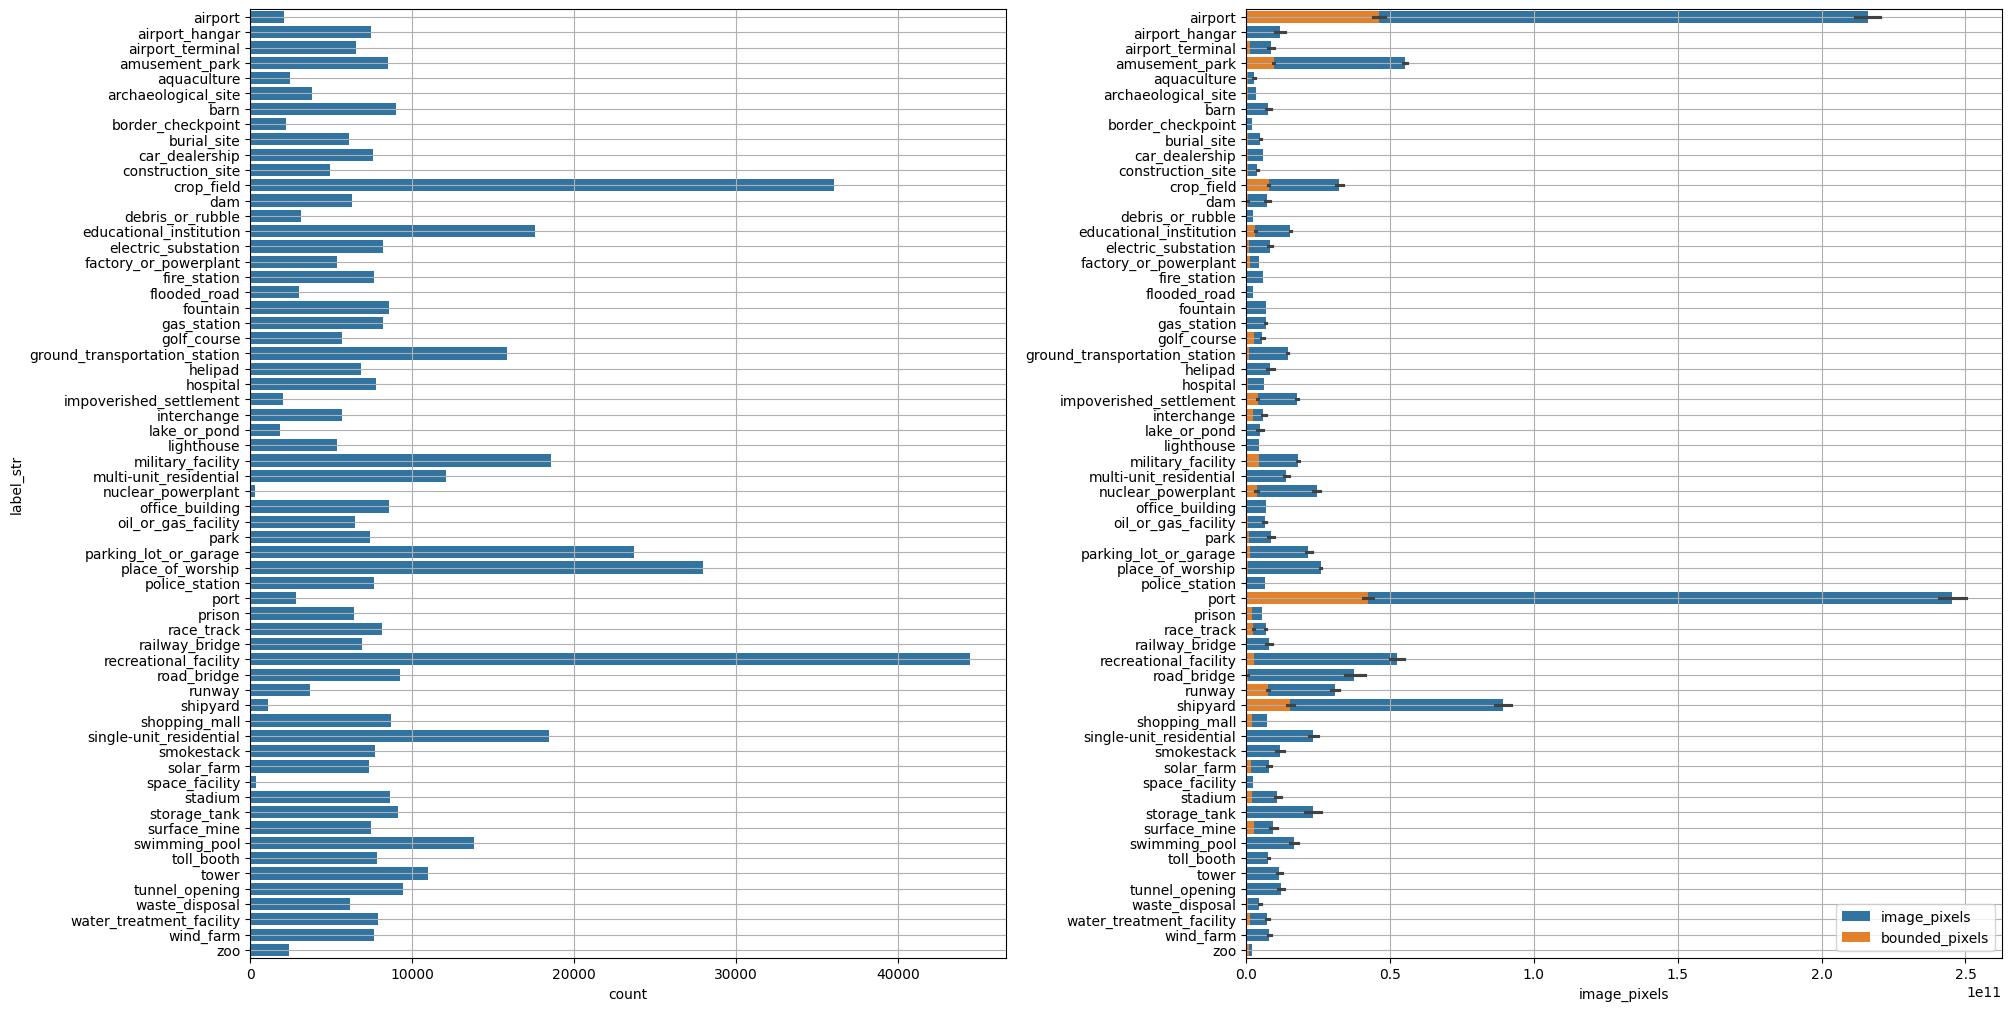

In [5]:
# Looking at the distribution of the # of images and # of pixels across the categories, a few observations can be made: 
# 1. There is no correlation between the image counts and pixel counts, meaning images sizes vary significantly across categories.
# 2. Some classes dominate the pixel distribution, indicating that images in these classes are much larger than those in other classes.
# 3. The ratio of bounded pixels to image pixels looks to be very small across classes, indicating lots of negative space in the images.

fig, ax = plt.subplots(1, 2, figsize = (20, 10), layout = "constrained")
sns.countplot(df, y="label_str", order=df["label_str"].sort_values(ascending=True), ax=ax[0])
sns.barplot(df, x="image_pixels", y="label_str", order=df["label_str"].sort_values(ascending=True), ax=ax[1], estimator="sum", label="image_pixels")
sns.barplot(df, x="bbox_pixels", y="label_str", order=df["label_str"].sort_values(ascending=True), ax=ax[1], estimator="sum", label="bounded_pixels")
ax[0].grid()
ax[1].grid()
ax[1].set_ylabel("")
ax[1].legend()

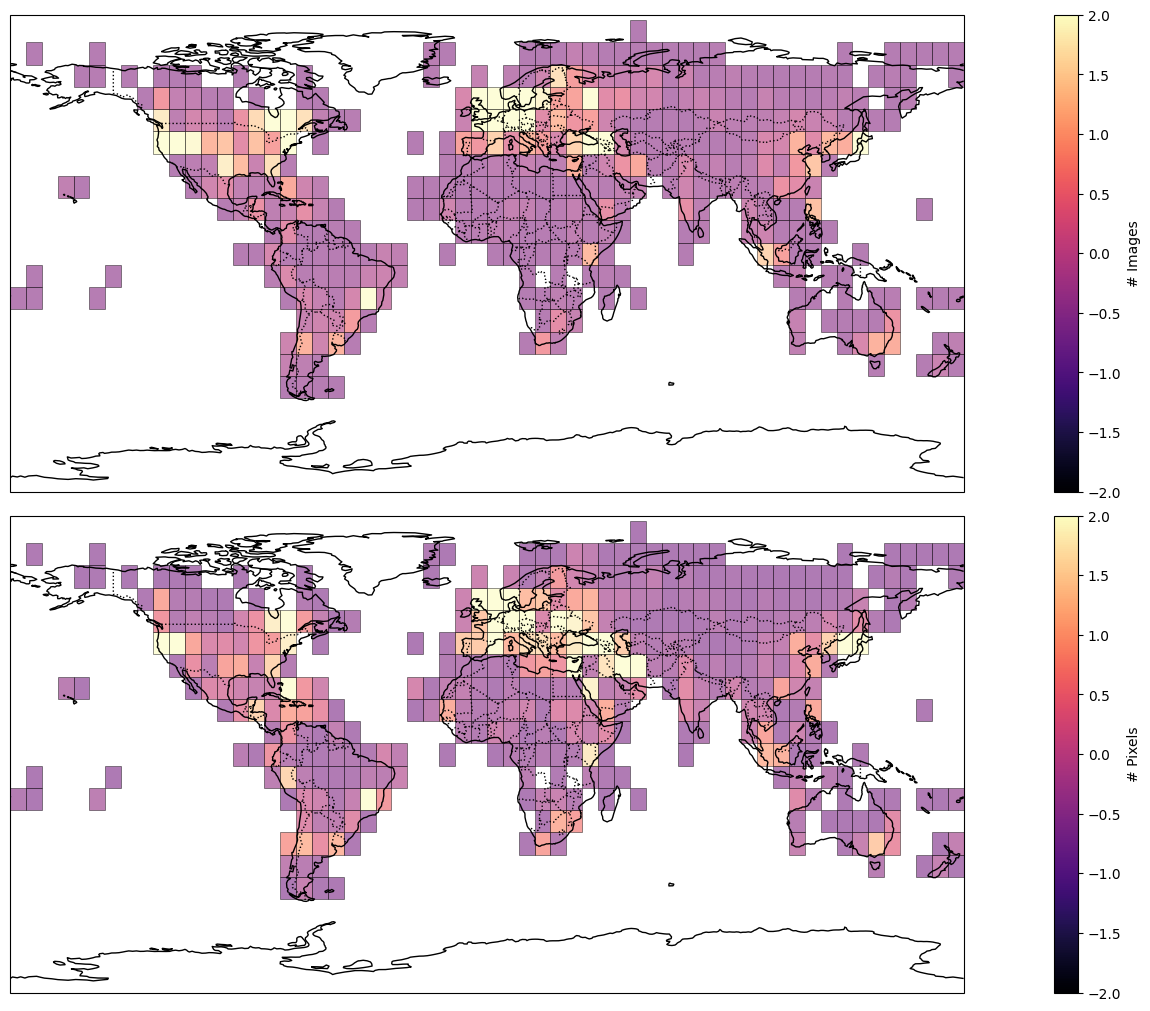

In [6]:
# Looking at the distributions of images and pixels globally,
# 1. Euro-Focus

# Function to get UTM zone bounding box (lon_min, lon_max, lat_min, lat_max)
def utm_zone_bbox(zone, band):
    """Get the bounding box of a UTM zone in lat/lon."""
    zone_number = int(zone)

    # Longitude bounds
    lon_min = (zone_number - 1) * 6 - 180
    lon_max = lon_min + 6

    # Latitude bands and their approximate boundaries
    lat_bands = "CDEFGHJKLMNPQRSTUVWX"  # UTM latitude bands
    lat_edges = np.linspace(-80, 88, len(lat_bands) + 1)  # Edges instead of centers
    lat_dict = dict(zip(lat_bands, zip(lat_edges[:-1], lat_edges[1:])))

    lat_min, lat_max = lat_dict.get(band, (-80, 80))  # Default to full range

    return lon_min, lon_max, lat_min, lat_max

# Sample UTM grid data with heatmap values
utm_df = df.groupby("utm").agg({"image_idx": "count", "image_pixels": "sum", "bbox_pixels": "sum"})
utm_df = (utm_df - utm_df.mean()) / utm_df.std()
utm_df = utm_df.reset_index(drop = False)

# Normalize values for colormap
norm = plt.Normalize(-2, 2)
cmap = plt.cm.magma

# Create figure with Cartopy
fig, ax = plt.subplots(2, 1, figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout = "constrained")

# Add map features
for a in ax.ravel():
    a.add_feature(cfeature.COASTLINE)
    a.add_feature(cfeature.BORDERS, linestyle=":")
    a.set_global()

for grid, count_val, area_val in zip(utm_df["utm"], utm_df["image_idx"], utm_df["image_pixels"]):
    zone, band = grid[:-1], grid[-1]
    lon_min, lon_max, lat_min, lat_max = utm_zone_bbox(zone, band)

    # Create a rectangle and add it to the plot
    ax[0].add_patch(Rectangle(
        (lon_min, lat_min), 6, lat_max - lat_min,  # (x, y), width, height
        facecolor=cmap(norm(count_val)), edgecolor='black', linewidth=0.5, alpha=0.6,
        transform=ccrs.PlateCarree()
    ))
    ax[1].add_patch(Rectangle(
        (lon_min, lat_min), 6, lat_max - lat_min,  # (x, y), width, height
        facecolor=cmap(norm(area_val)), edgecolor='black', linewidth=0.5, alpha=0.6,
        transform=ccrs.PlateCarree()
    ))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_a = plt.colorbar(sm, orientation="vertical", pad=0.05, ax = ax[0])
cbar_a.set_label("# Images")

cbar_b = plt.colorbar(sm, orientation="vertical", pad=0.05, ax = ax[1])
cbar_b.set_label("# Pixels")

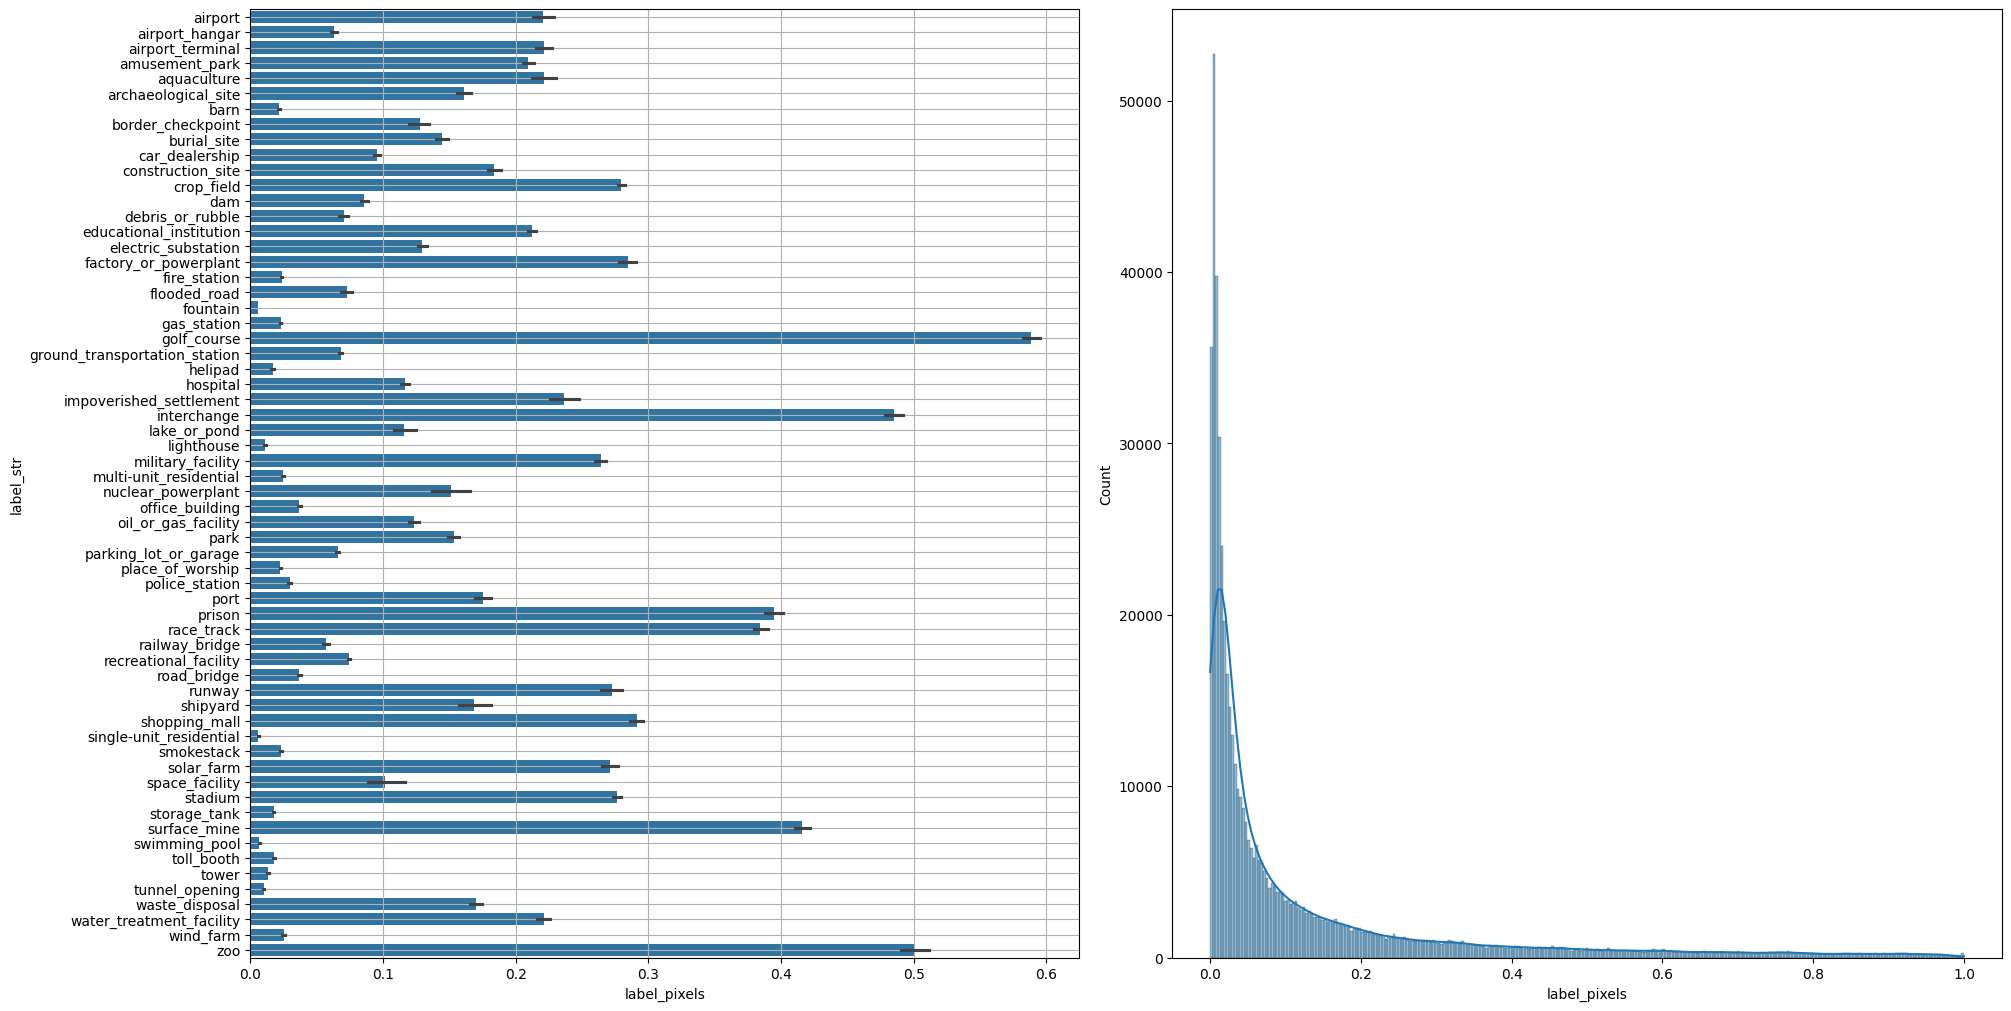

In [7]:
# Looking at the ratio of bounded pixels to image pixels (higher is better), we observe that
# 1. Most images have large amounts of background clutter, indicated by the small values for avg. label_pixels 
# 2. Distribution of background clutter across categories is also disproportionate w.r.t total pixels (from the previous graph). 
#   -> semantically, this makes sense. Relatively smaller objects, such as houses, towers, pools, fountains etc have large amounts of background,
#      while larger objects / locations such as golf courses, mines, airports, etc have less background. Background here means not being semantically
#      classified as the same category, eg. the road next to a residential unit is not part of the same category, but all the area covered by an
#      airport terminal is the airport

fig, ax = plt.subplots(1, 2, figsize = (20, 10), layout = "constrained")
sns.barplot(df, y = "label_str", x = "label_pixels", order = df["label_str"].sort_values(), ax = ax[0], estimator="mean")
sns.histplot(df, x = "label_pixels", kde = True, ax = ax[1])
ax[0].grid()

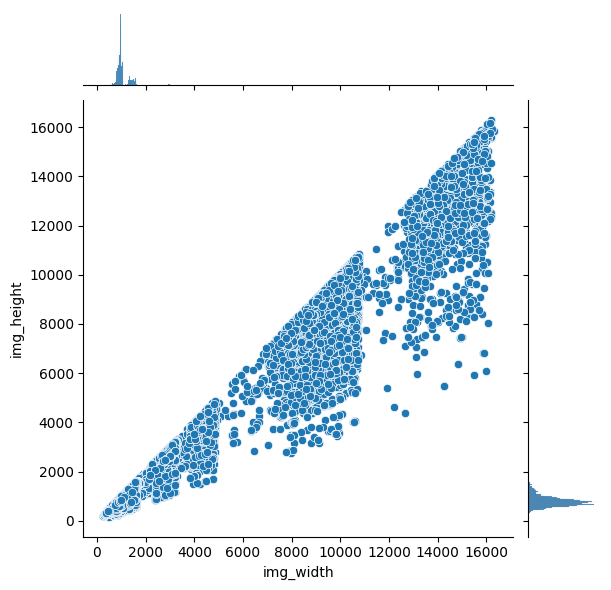

In [8]:
# Looking further into images sizes, we jointly plot the image dimensions across the dataset. Here, we observe that most images:
# 1. Have their largest dimension smaller than 2000x2000px 
# 2. Have their larger dimension being width, or both dimensions close to being equal.
sns.jointplot(df, x = "img_width", y = "img_height")

# 3. Larger images are skewing the distributions; thus splitting the dataset at this 2000px boundary might magnify smaller patterns being supressed.
large_df = df[(df["img_height"] > 2000) | (df["img_width"] > 2000)].copy()
small_df = df.drop(index = large_df.index).copy()

In [35]:
def get_bbox_union(bboxes: list[tuple[int, int, int, int]]) -> tuple[int, int, int, int]:
    y_min, x_min, y_max, x_max = int(9e4), int(9e4), 0, 0 
    for bbox in bboxes:
        if bbox[0] < y_min: y_min = bbox[0]
        if bbox[1] < x_min: x_min = bbox[1]
        if bbox[2] > y_max: y_max = bbox[2]
        if bbox[3] > x_max: x_max = bbox[3]
    return y_min, x_min, y_max, x_max

def get_bbox_dims(bbox: tuple[int, int, int, int]) -> tuple[int, int]:
    return bbox[2] - bbox[0], bbox[3] - bbox[1]

def get_bbox_square(row: pd.Series) -> pd.Series:
    # by row-major convention - dim_0: height, dim_1: width
    image_dims = row["img_height"], row["img_width"]
    bbox_tl, bbox_br = (row["new_image_bbox"][0], row["new_image_bbox"][1]), (row["new_image_bbox"][2], row["new_image_bbox"][3])
    bbox_dims = bbox_br[0] - bbox_tl[0], bbox_br[1] - bbox_tl[1]

    # bbox will be modified along the smaller dimension of the bbox, sdim
    sdim = np.argmin(bbox_dims)
    ldim = np.abs(sdim - 1)

    # skip over images smaller than 2000x2000
    # if image_dims[ldim] < 2000:
        # return 0, 0, *image_dims
    
    # calculate corrections along the smaller dimension 
    avail_before = bbox_tl[sdim] 
    avail_after = image_dims[ldim] - bbox_br[ldim]
    reqd = bbox_dims[ldim] - bbox_dims[sdim]
    if reqd % 2 == 0:
        reqd_before, reqd_after = reqd // 2, reqd // 2 
    else:
        reqd_before, reqd_after = (reqd // 2) + 1, reqd // 2

    # ajust corrections if bbox is not roughly in the center and there aren't enough pixels along
    # the smaller dimension; as much of the image as possible will be used
    if avail_before < reqd_before:
        reqd_after = min(avail_after, reqd_after + reqd_before - avail_before)
        reqd_before = avail_before
    elif avail_after < reqd_after:
        reqd_before = min(avail_before, reqd_before + reqd_after - avail_after)
        reqd_after = avail_after
    
    # apply the corrections
    new_bbox_tl = list(bbox_tl)
    new_bbox_tl[sdim] -= reqd_before
    new_bbox_br = list(bbox_br)
    new_bbox_br[sdim] += reqd_after

    return *new_bbox_tl, *new_bbox_br


union_df = index_df[["image_path", "label_str", "label_bbox"]].merge(spatial_df[["img_height", "img_width"]], how = "left", left_index=True, right_index=True)
union_df["new_image_bbox"] = union_df["label_bbox"].apply(get_bbox_union)
union_df["new_image_bbox"] = union_df.apply(get_bbox_square, axis = 1)
union_df[["new_image_width", "new_image_height"]] = union_df["new_image_bbox"].apply(get_bbox_dims).to_list()
union_df

,image_path,label_str,label_bbox,img_height,img_width,new_image_bbox,new_image_width,new_image_height
0,seq_gt/airport/airport_0/airport_0_0_rgb.jpg,"(airport,)","((3548, 3702, 4817, 4829),)",8792,8792,"(3548, 3631, 4817, 4900)",1269,1269
1,seq_gt/airport/airport_0/airport_0_1_rgb.jpg,"(airport,)","((3481, 3631, 4725, 4737),)",8624,8624,"(3481, 3562, 4725, 4806)",1244,1244
2,seq_gt/airport/airport_1/airport_1_0_rgb.jpg,"(airport,)","((2874, 3021, 4496, 4924),)",7591,7793,"(2733, 3021, 4636, 4924)",1903,1903
3,seq_gt/airport/airport_1/airport_1_2_rgb.jpg,"(airport,)","((3033, 3188, 4745, 5198),)",8014,8226,"(2884, 3188, 4894, 5198)",2010,2010
4,seq_gt/airport/airport_1/airport_1_3_rgb.jpg,"(airport,)","((3495, 3673, 5468, 5987),)",9230,9474,"(3324, 3673, 5638, 5987)",2314,2314
...,...,...,...,...,...,...,...,...
523841,val/zoo/zoo_9/zoo_9_5_rgb.jpg,"(zoo,)","((262, 194, 462, 620),)",753,871,"(149, 194, 575, 620)",426,426
523842,val/zoo/zoo_9/zoo_9_6_rgb.jpg,"(zoo,)","((282, 208, 496, 664),)",807,933,"(161, 208, 617, 664)",456,456
523843,val/zoo/zoo_9/zoo_9_7_rgb.jpg,"(zoo,)","((332, 246, 586, 785),)",955,1105,"(189, 246, 728, 785)",539,539
523844,val/zoo/zoo_9/zoo_9_8_rgb.jpg,"(zoo,)","((284, 210, 501, 672),)",816,944,"(161, 210, 623, 672)",462,462


(np.float64(-0.5), np.float64(1468.5), np.float64(1414.5), np.float64(-0.5))

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

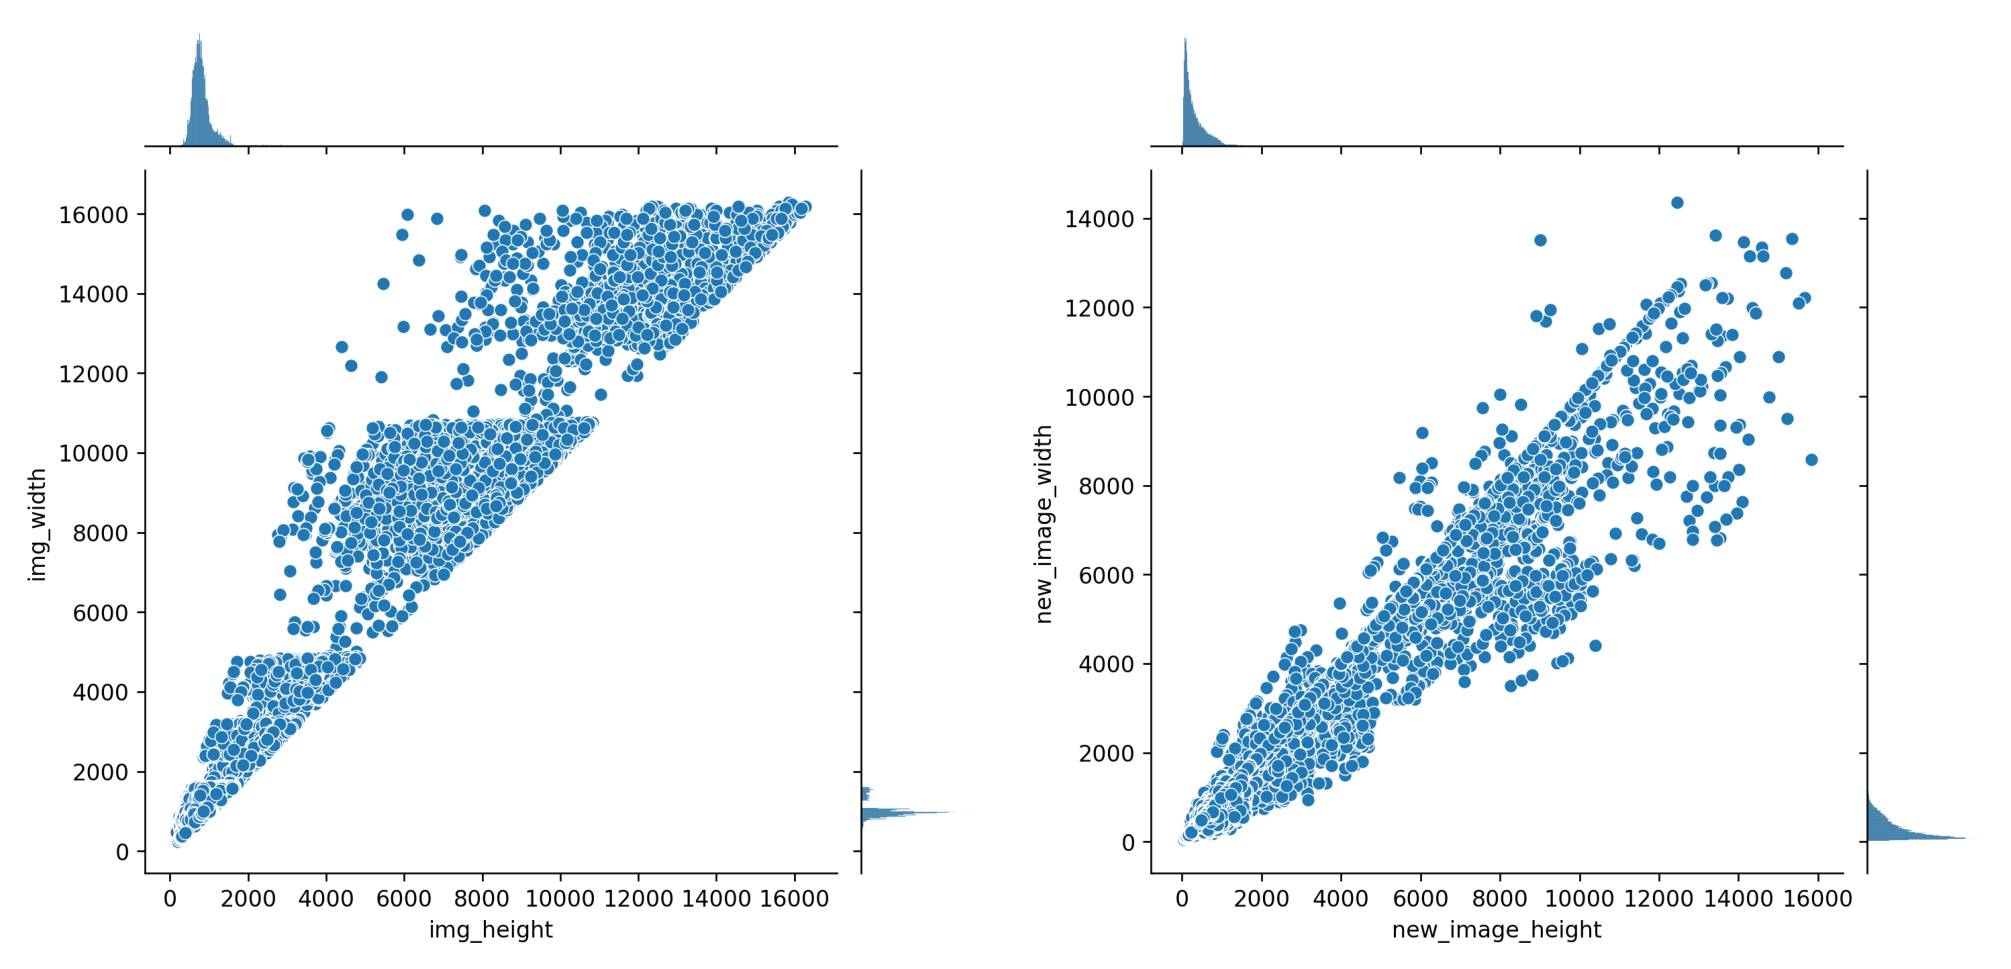

In [42]:
sns.jointplot(union_df, x = "new_image_height", y = "new_image_width").savefig("fmow_new_image_jointplot.png", dpi = 240); plt.clf()
sns.jointplot(union_df, x = "img_height", y = "img_width").savefig("fmow_image_jointplot.png", dpi = 240); plt.clf()
fig, ax = plt.subplots(1, 2, figsize = (20, 10), layout = "constrained")
ax[0].imshow(Image.open("fmow_image_jointplot.png"))
ax[1].imshow(Image.open("fmow_new_image_jointplot.png"))

ax[0].axis("off")
ax[1].axis("off")

<Axes: xlabel='new_image_width', ylabel='Count'>

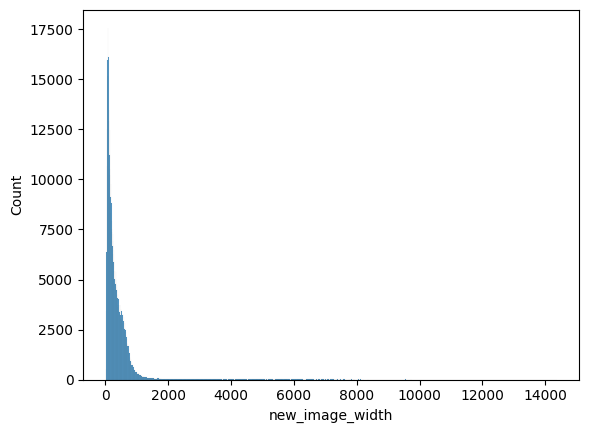

In [44]:
sns.histplot(union_df, x = "new_image_width")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20,10), layout = "constrained")
sns.barplot(small_df, y = "label_str", x = "image_pixels", estimator="sum", order = df["label_str"].sort_values(), ax = ax[0], label = "image_pixels")
sns.barplot(small_df, y = "label_str", x = "bbox_pixels", estimator="sum", ax = ax[0], label = "bounded_pixels")

sns.barplot(large_df, y = "label_str", x = "image_pixels", estimator="sum", order = df["label_str"].sort_values(), ax = ax[1], label = "image_pixels")
sns.barplot(large_df, y = "label_str", x = "bbox_pixels", estimator="sum", ax = ax[1], label = "bounded_pixels")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10), layout = "constrained")
sns.boxplot(df, x = "image_aspect", y = "label_str", order = df["label_str"].sort_values(), ax = ax[0])
sns.histplot(df, x = "image_aspect", kde = True, ax = ax[1])
ax[0].grid()
ax[1].grid()

In [ ]:
sns.jointplot(df, x = "bbox_width", y = "bbox_height")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10), layout = "constrained")
sns.boxplot(df, x = "bbox_aspect", y = "label_str", order = df["label_str"].sort_values(), ax = ax[0])
sns.histplot(df, x = "bbox_aspect", ax = ax[1])
ax[0].grid()
ax[0].set_xlim(-0.1, 5.0)
ax[1].grid()
ax[1].set_xlim(-0.1, 5.0)

In [ ]:
import shapely.geometry
from numpy.typing import NDArray

import h5py
import folium
import shapely
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import imageio.v3 as iio
import matplotlib.pyplot as plt
from tqdm import tqdm

from pathlib import Path
from geovision.data.fmow import FMoW

In [ ]:
def load_image(df: pd.DataFrame, idx: int):
    return iio.imread(FMoW.local_staging/"rgb"/df.iloc[idx]["image_path"])

def plot_original_image_with_bboxes(df: pd.DataFrame, idx: int):
    row = df.iloc[idx]
    _, ax = plt.subplots(1,1, figsize = (10, 10))
    ax.imshow(load_image(df, idx))
    ax.add_patch(FMoW.get_rectangle_from_corners(
        (row["bbox_tl_0"], row["bbox_tl_1"]), (row["bbox_br_0"], row["bbox_br_1"]), fill = False, linewidth = 3, color = "red")
    )
    ax.add_patch(FMoW.get_rectangle_from_corners(
        (row["outer_bbox_tl_0"], row["outer_bbox_tl_1"]), (row["outer_bbox_br_0"], row["outer_bbox_br_1"]), fill = False, linewidth = 3, color = "blue")
    )
    
def crop_and_plot_image_with_bboxes(df: pd.DataFrame, idx: int):
    row = df.iloc[idx]
    image = load_image(df, idx) 
    image = image[row["outer_bbox_tl_0"]:row["outer_bbox_br_0"], row["outer_bbox_tl_1"]:row["outer_bbox_br_1"], :]

    _, ax = plt.subplots(1,1, figsize = (5,5))
    ax.imshow(image)
    ax.add_patch(FMoW.get_rectangle_from_corners(
        (row["inner_bbox_tl_0"], row["inner_bbox_tl_1"]), (row["inner_bbox_br_0"], row["inner_bbox_br_1"]), fill = False, linewidth = 3, color = "red")
    )

def plot_original_image_on_map(row: pd.Series):
    pass

def targer_bbox_to_geometry(row: pd.Series) -> shapely.geometry.Polygon:
    pass

def geometry_to_outer_bbox(row: pd.Series) -> tuple[int, int, int, int]:
    pass

def calculate_outer_bbox_from_geometry(row: pd.Series) -> tuple[int, int, int, int]:
    # long, lat <==> width, height
    pixel_dims = row["mean_pixel_width"], row["mean_pixel_height"]
    outer_tl = np.array(row["geometry"].exterior.coords[0])
    inner_tl, _, inner_br, _ = [np.array(point) for point in row["intersect"].exterior.coords[:4]]

    tl = np.floor((inner_tl - outer_tl) * pixel_dims).astype(np.uint32)
    br = np.ceil((inner_br - outer_tl) * pixel_dims).astype(np.uint32)

    return tl[1], tl[0], br[1], br[0]

def bbox_to_geometry(geometry, height, width, tl_0, tl_1, br_0, br_1, step_0, step_1) -> shapely.geometry.Polygon:
    # geometry conventions are long, lat because of epsg:4326, opposite of bbox row, column
    tl, tr, br, bl = [np.array(point) for point in geometry.exterior.coords[:4]]

    def shift_right(point: NDArray, by: int):
        point[0] += by*step_1
        return point

    def shift_down(point: NDArray, by: int):
        point[1] += by*step_0
        return point 

    tl = shift_down(tl, tl_0)
    tl = shift_right(tl, tl_1)

    tr = shift_down(tr, tl_0)
    tr = shift_right(tr, br_1 - width)

    br = shift_down(br, br_0 - height)
    br = shift_right(br, br_1 - width)

    bl = shift_down(bl, br_0 - height)
    bl = shift_right(bl, tl_1)

    return shapely.Polygon([tl, tr, br, bl, tl])

In [ ]:
df = FMoW.get_multiclass_classification_df_from_metadata()
df = df[df.country_code == "IND"].reset_index()

In [ ]:
plot_original_image_with_bboxes(df, 0)

In [ ]:
r = df.iloc[10]
print(r.utm)
r.geometry.project(r.utm)

In [ ]:
row = df.iloc[0]
print(row.mean_pixel_height, row.mean_pixel_width)
tl_0, tl_1, br_0, br_1 = row.geometry.bounds

bbox_tl_0, bbox_tl_1, bbox_br_0, bbox_br_1 = bbox_to_geometry(
    row.geometry, row.img_height, row.img_width, 
    row.bbox_tl_0, row.bbox_tl_1, row.bbox_br_0, row.bbox_br_1, 
    row.mean_pixel_height, row.mean_pixel_width
).bounds

outer_bbox_tl_0, outer_bbox_tl_1, outer_bbox_br_0, outer_bbox_br_1 = bbox_to_geometry(
    row.geometry, row.img_height, row.img_width, 
    row.outer_bbox_tl_0, row.outer_bbox_tl_1, row.outer_bbox_br_0, row.outer_bbox_br_1, 
    row.mean_pixel_height, row.mean_pixel_width
).bounds

print(row.label_str, row.country_code, row.geometry.centroid.coords[0])

map = folium.Map(location = tuple(reversed(row.geometry.centroid.coords[0])))
folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True).add_to(map)

map.add_child(folium.Rectangle(bounds = ((tl_1, tl_0), (br_1, br_0))))
map.add_child(folium.Rectangle(bounds = ((bbox_tl_1, bbox_tl_0), (bbox_br_1, bbox_br_0)), color = "red"))
map.add_child(folium.Rectangle(bounds = ((outer_bbox_tl_1, outer_bbox_tl_0), (outer_bbox_br_1, outer_bbox_br_0))))

In [ ]:
idx = 350840 
wkt_str = str(df.iloc[idx]["raw_location"]).removeprefix("POLYGON ((").removesuffix("))")
polygon = shapely.from_wkt(df.iloc[idx]["raw_location"])

In [ ]:
plt

In [ ]:
# Image Height vs Width
# Insight: very few images are larger than 2000x2000px 
sns.jointplot(df, x = "width", y = "height")
print(df.apply(lambda x: True if x["width"] > 2000 or x["height"] > 2000 else False, axis = 1).sum(), "images have a dimention larger than 2000x2000px")

In [ ]:
# Classwise Distribution of Heights and Widths
# Insight: airport, amusement_park, impoverished_settlement, nuclear_powerplant, port, runway, shipyard and space facility are
# the ones with images > 2000px mostly, with a few outliers from each class
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.boxplot(df, y = "label_str", x = "height", ax = axes[0])
sns.boxplot(df, y = "label_str", x = "width", ax = axes[1])

In [ ]:
sns.jointplot(df, x = "bbox_width", y = "bbox_height")
print(df.apply(lambda x: True if x["width"] > 2000 or x["height"] > 2000 else False, axis = 1).sum(), "bboxes > 2000x2000px")

In [ ]:
df["bbox_height"] = df.apply(lambda x: x["bbox_br_0"] - x["bbox_tl_0"], axis = 1) 
df["bbox_width"] = df.apply(lambda x: x["bbox_br_1"] - x["bbox_tl_1"], axis = 1) 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.boxplot(df, y = "label_str", x = "bbox_height", ax = axes[0])
sns.boxplot(df, y = "label_str", x = "bbox_width", ax = axes[1])

In [ ]:
# Classwise distribution of images and pixels enclosed by bboxes
fig, axes = plt.subplots(1,2, figsize = (20, 15))
df["num_bbox_pixels"] = df.apply(lambda x: x["bbox_height"]*x["bbox_width"], axis = 1)
sns.barplot(df.groupby("label_str").count().reset_index(drop = False), y = "label_str", x = "image_path", ax = axes[0])
sns.barplot(df[["label_str", "num_bbox_pixels"]].groupby("label_str").sum().reset_index(drop = False), y = "label_str", x = "num_bbox_pixels", ax = axes[1])